## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* s3fs
* zarr

In [ ]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs zarr

     |████████████████████████████████| 4.1MB 4.5MB/s 
     |████████████████████████████████| 3.3MB 30.9MB/s 
     |████████████████████████████████| 327kB 47.7MB/s 
     |████████████████████████████████| 3.8MB 42.2MB/s 
  Created wheel for zarr: filename=zarr-2.4.0-cp36-none-any.whl size=127066 sha256=d23e66265848be319a59f4b1d68a745fde1092877787dc5c19db38d7c35380f3
  Stored in directory: /root/.cache/pip/wheels/e1/5b/25/24c685604b91139aba00a5b6299b53e7a0661f737f27782559
  Created wheel for asciitree: filename=asciitree-0.3.3-cp36-none-any.whl size=5037 sha256=af10d2eaf7c1738901f203a335cbdd63ab52bfbbcfa2d83ce301c78a96c28e47
  Stored in directory: /root/.cache/pip/wheels/1d/d9/58/9808b306744df0208fccc640d3d9952a5bc7468502d42897d5
  Created wheel for numcodecs: filename=numcodecs-0.6.4-cp36-cp36m-linux_x86_64.whl size=3881186 sha256=c9bb87a62eb6f4ca1cb616b2db3d898da402e480dc9a992c880c8bacf4b45705
  Stored in directory: /root/.cache/pip/wheels/ca/07/ed/fea2e120cbb91d90b577c5ac56b4b08202

In [ ]:
# if working on google colab
! pip install -U -q PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Data
The datasets consist of synthetically-generated holograms of cloud droplets.  Each dataset is in zarr format, and contains a series of hologram images as well as the properties of each particle in the image.  The zarr variable names and properties are as follows:

| Variable Name | Description | Dimensions | Units/Range|
| ------------- | :----:|:----------- |:------|
| image  | Stack of single-color images. Each image is 600x400 pixels, ranging from 0-255 in intensity. | nHolograms, 600, 400 | 0 to 255 (grayscale image) |
| x  |  X-position of each particle in the dataset.  The origin is at the center of the hologram image. | nParticles (can vary) | -888 to 888 micrometers |
| y  | Y-position of each particle in the dataset.  The origin is at the center of the hologram image. |  nParticles (can vary) | -592 to 592 micrometers |
| z  | Z-position of each particle in the dataset.  The origin is at the focal plane of the instrument (all particles are unfocused). | nParticles (can vary) | 14000 to 158000 micrometers |
| d  | Diameter of each simulated droplet | nParticles (can vary) | 20 to 70 micrometers |
| hid | Hologram ID specifies which hologram this particle is contained in.  For example, if hid=1, the corresponding x, y, z, and d variables are found in the first hologram. | nParticles (can vary) | 1 to nHolograms |
| Dx (global attribute) | Resolution of each pixel, == 2.96 micrometers.  Use if you wish to convert x/y position to pixel number |  |  |

There are two datasets for this project, a single-particle dataset and a three-particle dataset.  The single-particle dataset only contains one particle per hologram (nHolograms = nParticles). There are 50,000 holograms in the training dataset that correspond to 50,000 particles.

The three-particle dataset contains three particles per hologram.  This dataset also contains 50,000 holograms but 150,000 particles.  Be sure to use the hid variable to figure out which hologram a particle is contained in.

The ultimate goal of this project is to be able to find particles in the holograms and determine their x, y, z, and d values. This process is straightforward for finding a single particle, but finding multiple particles and their properties is much more challenging. A simpler objective that could also assist in speeding up the HOLODEC processing is calculating the relative distribution of particle mass in the z-direction from the holograms, which is a combination of information from z and d. 

<center><img src='holodec_images/image4.png'><center>


### Potential Input Variables
| Variable Name | Units | Description | Relevance |
| ------------- | :----:|:----------- | :--------:|
| hologram   |  arbitrary |  8 bit (0-255) amplitude captured by CCD  | standard input data for processing  |


### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |
| hid | arbitrary | hologram ID by particle|


### Training Set

The single-particle training dataset is in the zarr format described above, with 15,000 holograms and 15,000 corresponding particles.

The three-particle training dataset contains 15,000 holograms and 45,000 particles.


### Validation Set
The single-particle validation dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle validation dataset contains 5,000 holograms and 15,000 particles.


### Test Set
The single-particle test dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle test dataset contains 5,000 holograms and 15,000 particles.


### Data Transforms

The input images only need to be normalized between 0 and 1 by dividing by 255. 


In [ ]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)


In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 3
output_cols = ["hid", "x", "y", "z", "d"]
num_z_bins = 20
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled,\
train_outputs,\
scaler_vals = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled,\
valid_outputs, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 5)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [ ]:
# Plot a single hologram with the particles overlaid
def plot_hologram(h, outputs):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, train_inputs_scaled[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, train_inputs_scaled[h, :, :, 0].shape[1])

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x_vals, y_vals, train_inputs_scaled[h, :, :, 0].T, cmap="RdBu_r")
    h_particles = np.where(outputs["hid"] == h + 1)[0]
    for h_particle in h_particles:
        plt.scatter(outputs.loc[h_particle, "x"],
                    outputs.loc[h_particle, "y"],
                    outputs.loc[h_particle, "d"] ** 2,
                    outputs.loc[h_particle, "z"],
                    vmin=outputs["z"].min(),
                    vmax=outputs["z"].max(),
                    cmap="cool")
        plt.annotate(f"d: {outputs.loc[h_particle,'d']:.1f} µm",
                     (outputs.loc[h_particle, "x"], outputs.loc[h_particle, "y"]))
    plt.xlabel("horizontal particle position (µm)", fontsize=16)
    plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title("Hologram and particle positions plotted in four dimensions", fontsize=20, pad=20)
    plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)


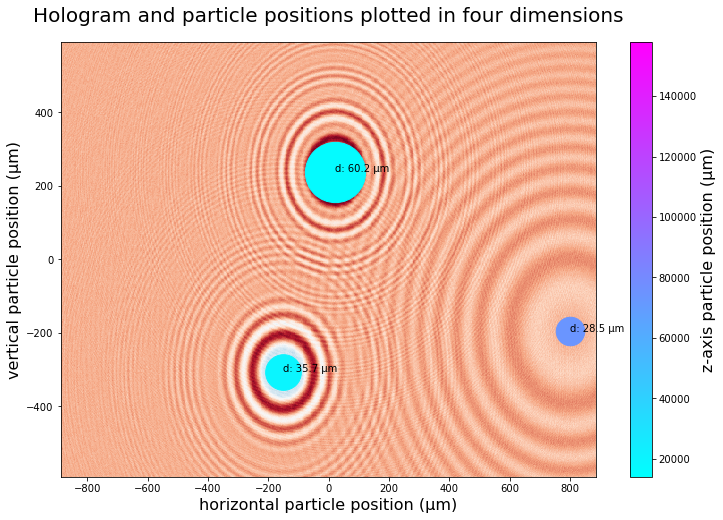

In [ ]:
h = 300
plot_hologram(h, train_outputs)

## Baseline Machine Learning Model
A baseline model for solving this problem uses a ConvNET architecture implemented in Keras.  The first three convolution layers consist of 5 x 5 pixel kernels with rectified linear unit (relu) activation followed by a 4 x 4 pixel max pool layer.  The first convolution layer has 8 channels, the second contains 16 channels, and the third contains 32 channels.  The output of the third convolution layer is flattened and fed into a dense layer with 64 neurons and relu activation.  Finally the output layer consists of the relative mass in 20 bins.  The model is trained using a mean absolute error and categorical cross-entropy loss function.

Training time: 20 epochs in ~2.5 minutes


In [ ]:
class Conv2DNeuralNetwork(object):
    """
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, filters=(8,), kernel_sizes=(5,), conv2d_activation="relu",
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.filters = filters
        self.kernel_sizes = [tuple((v,v)) for v in kernel_sizes]
        self.conv2d_activation = conv2d_activation
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        for h in range(len(self.filters)):
            nn_model = Conv2D(self.filters[h], self.kernel_sizes[h], padding="same",
                              activation=self.conv2d_activation, name=f"conv2D_{h:02d}")(nn_model)
            nn_model = MaxPool2D(self.pool_sizes[h], name=f"maxpool2D_{h:02d}")(nn_model)
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


### Z Relative Particle Mass Model
This neural network is tasked to predict the distribution of particle mass in the z-plane of the instrument. The relative mass is calculated by calculating the volume of each sphere based on the area and dividing by the total mass of all particles. The advantage of this target is that it behaves like a probability density function and sums to 1, and it is agnostic to the number of particles in the image.


In [ ]:
def calc_z_relative_mass(outputs, holograms, num_z_bins=20, z_bins=None):
    """
    Calculate z-relative mass from particle data.
    
    Args: 
        outputs: (np array) Output data previously specified by output_cols 
        holograms: (int) Number of holograms
        num_z_bins: (int) Number of bins for z_bins linspace
        z_bins: (np array) Bin linspace along the z-axis
    
    Returns:
        z_mass: (np array) Particle mass distribution by hologram
        z_bins: (np array) Bin linspace along the z-axis
    """
    
    if z_bins is None:
        z_bins = np.linspace(outputs["z"].min()- 100, outputs["z"].max() + 100, num_z_bins)
        print(z_bins)
    else:
        num_z_bins = z_bins.size
    z_mass = np.zeros((holograms, num_z_bins), dtype=np.float32)
    for i in range(outputs.shape[0]):
        z_pos = np.searchsorted(z_bins, outputs.loc[i, "z"], side="right") - 1
#         print(i, outputs.loc[i, "z"], z_pos)
        mass = 4 / 3 * np.pi * (outputs.loc[i, "d"])**3
#         print("\t", mass, int(outputs.loc[i, "hid"]) - 1)
        z_mass[int(outputs.loc[i, "hid"]) - 1, z_pos] += mass
    z_mass /= np.expand_dims(z_mass.sum(axis=1), -1)
    print(f"z_mass.shape: {z_mass.shape}\nz_bins.shape: {z_bins.shape}")
    return z_mass, z_bins


In [ ]:
z_bins = np.linspace(np.minimum(train_outputs["z"].min(), valid_outputs["z"].min()),
                     np.maximum(train_outputs["z"].max(), valid_outputs["z"].max()),
                     num_z_bins)

train_z_mass, _ = calc_z_relative_mass(train_outputs, len(train_outputs["hid"].unique()), z_bins=z_bins)
valid_z_mass, _ = calc_z_relative_mass(valid_outputs, len(valid_outputs["hid"].unique()), z_bins=z_bins)
train_inputs_scaled = train_inputs_scaled[0::3]
valid_inputs_scaled = train_inputs_scaled[0::3]

z_mass.shape: (2000, 20)
z_bins.shape: (20,)
z_mass.shape: (667, 20)
z_bins.shape: (20,)


### Three particle, z-mass model definition

In [ ]:
# conv2d_network definitions for 3 particle z mass solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/3particle_base"
else:
    path_out = "./holodec_models/3particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "elu"
lr = 0.0003
decay = 0.1
optimizer = "adam"
loss = "categorical_crossentropy"
batch_size = 128
epochs = 40
verbose = 1

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [ ]:
# 3 particle z mass model build, compile, fit, and predict

three_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes,
                              conv2d_activation=conv2d_activation,
                              pool_sizes=pool_sizes, dense_sizes=dense_sizes,
                              dense_activation=dense_activation, lr=lr,
                              optimizer=optimizer, decay=decay, loss=loss,
                              batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist = mod.fit(train_inputs_scaled, train_z_mass, valid_inputs_scaled, valid_z_mass)
    
    train_z_mass_pred = mod.predict(train_inputs_scaled)
    valid_z_mass_pred = mod.predict(valid_inputs_scaled)
print(f"Running model took {datetime.now() - three_start} time")


In [ ]:
# visualize loss history

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
# save the model
print("Saving the model")
mod.model.save(join(path_out, model_name +".h5"))

In [ ]:
# clear your tf session without needing to re-load and re-scale data

del mod
tf.keras.backend.clear_session()


### Three Particle Metrics

How well do individual predictions (red) match with the actual particle locations (blue)?


In [ ]:
valid_index = 11
bin_size = z_bins[1] - z_bins[0]
plt.figure(figsize=(10, 6))
plt.bar(z_bins / 1000, valid_z_mass_pred[valid_index], bin_size / 1000, color='red', label="Predicted")
plt.bar(z_bins / 1000, valid_z_mass[valid_index], bin_size / 1000, edgecolor='blue', facecolor="none", lw=3, label="True")
plt.ylim(0, 1)
plt.xlabel("z-axis particle position (mm)", fontsize=16)
plt.ylabel("relative mass", fontsize=16)
plt.legend(loc="best")

If the model was completely unbiased, then mean relative mass in each bin should be nearly the same across all validation examples. In this case we see that the CNN preferentially predicts that the mass is closer to the camera, likely due to a combination of particles closer to the camera blocking those farther away along with more distant particles influencing the entire image. Since the CNN assumes image properties are more localized, it will struggle to detect the particles that are farther away.

In [ ]:
plt.bar(z_bins / 1000, valid_z_mass_pred.mean(axis=0), (z_bins[1] - z_bins[0]) / 1000, color='red')
plt.bar(z_bins / 1000, valid_z_mass.mean(axis=0), (z_bins[1]-z_bins[0]) / 1000, edgecolor='blue', facecolor="none", lw=3)
plt.xlabel("z location (mm)", fontsize=16)
plt.ylabel("Mean Relative Mass", fontsize=16)

In [ ]:
def ranked_probability_score(y_true, y_pred):
    return np.mean((np.cumsum(y_true, axis=1) - np.cumsum(y_pred, axis=1)) ** 2) / (y_true.shape[1] -1)

In [ ]:
rps_nn = ranked_probability_score(valid_z_mass, valid_z_mass_pred)
rps_climo = ranked_probability_score(valid_z_mass, np.ones(valid_z_mass_pred.shape) / valid_z_mass_pred.shape[1])
print(rps_nn, rps_climo)
rpss = 1 - rps_nn / rps_climo
print(f"RPSS: {rpss:0.3f}")

### One Particle Model
An easier problem is predicting the location and properties of synthetic single particles.


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


In [ ]:
# conv2d_network definitions for 1 particle 4D solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "relu"
lr = 0.0001
optimizer = "adam"
loss = "mae"
batch_size = 128
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)


In [ ]:
# 1 particle 4D model build, compile, fit, and predict

one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 600, 400, 16)      416       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 150, 100, 16)      0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 150, 100, 24)      9624      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 37, 25, 24)        0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 37, 25, 32)        19232     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 9, 6, 32)          0     

In [ ]:
print(train_preds_scaled_one.shape)

(6000, 4)


In [ ]:
# inverse transform of scaled predictions

train_preds_one = pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one.values), columns=output_cols_one)
valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one.values), columns=output_cols_one)


### One Particle Metrics
An ideal solution to HOLODEC processing would leverage all the advantages of the instrument (unparalleled particle position and size accuracy) but reduce the drawbacks (processing time).  For this reason, the major components of the model assessment should include:

Mean absolute error in predictions for single-particle dataset:

| Variable Name | Error |
| ------------- |:----------- |
| x  |  20 µm     |
| y  |  12 µm     |
| z  |  2519 µm     |
| d  |  1 µm     |



In [ ]:
# calculate error by output_cols_one

valid_maes_one = np.zeros(len(output_cols_one))
max_errors_one = np.zeros(len(output_cols_one))
for o, output_col in enumerate(output_cols_one):
    valid_maes_one[o] = mean_absolute_error(valid_outputs_one[output_col], valid_preds_one[output_col])
    max_errors_one[o] = max_error(valid_outputs_one[output_col], valid_preds_one[output_col])

    print(f"{output_col} MAE: {valid_maes_one[o]:,.0f} µm \t\t Max Error: {max_errors_one[o]:,.0f} µm")


## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here


#### Task1: Load the data

In [ ]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 3
output_cols = ["hid", "x", "y", "z", "d"]
num_z_bins = 20
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled,\
train_outputs,\
scaler_vals = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled,\
valid_outputs, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 5)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


#### Task2: Create an exploratory visualization of the data

In [ ]:
# Plot a single hologram with the particles overlaid
def plot_hologram(h, outputs):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, train_inputs_scaled[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, train_inputs_scaled[h, :, :, 0].shape[1])

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x_vals, y_vals, train_inputs_scaled[h, :, :, 0].T, cmap="RdBu_r")
    h_particles = np.where(outputs["hid"] == h + 1)[0]
    for h_particle in h_particles:
        plt.scatter(outputs.loc[h_particle, "x"],
                    outputs.loc[h_particle, "y"],
                    outputs.loc[h_particle, "d"] ** 2,
                    outputs.loc[h_particle, "z"],
                    vmin=outputs["z"].min(),
                    vmax=outputs["z"].max(),
                    cmap="cool")
        plt.annotate(f"d: {outputs.loc[h_particle,'d']:.1f} µm",
                     (outputs.loc[h_particle, "x"], outputs.loc[h_particle, "y"]))
    plt.xlabel("horizontal particle position (µm)", fontsize=16)
    plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title("Hologram and particle positions plotted in four dimensions,h="+str(h), fontsize=20, pad=20)
    plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)


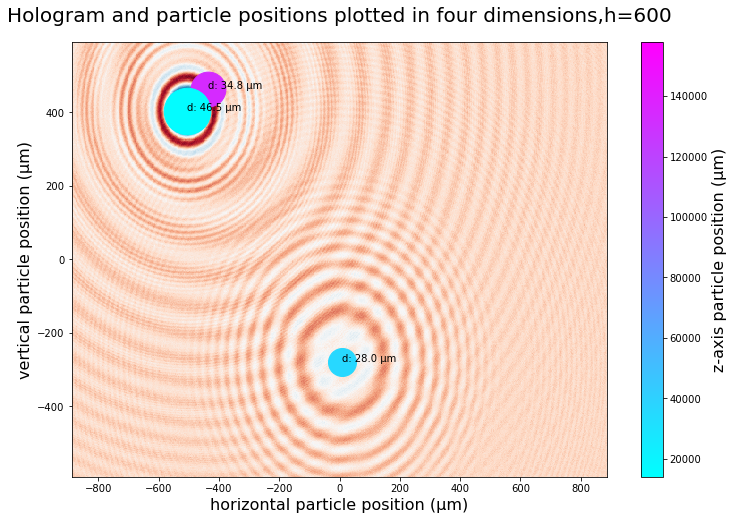

In [ ]:
h = 600
plot_hologram(h, train_outputs)

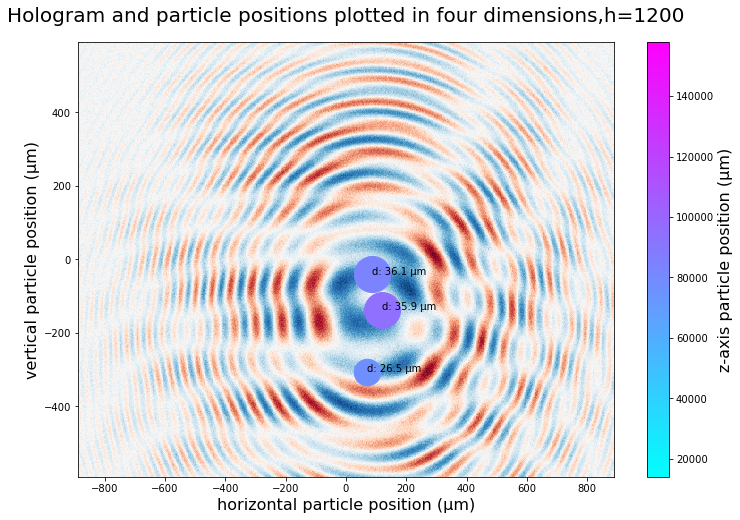

In [ ]:
h = 1200
plot_hologram(h, train_outputs)

#### Task3: Test two different transformation and scaling methods

In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
#scaler_one= StandardScaler()
slice_idx = 6000


#### Task4: Test one dimensionality reduction method-PCA

In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


Slicing data into inputs/outputs
	- outputs.shape: (6000, 4)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 4)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [ ]:
pip install scikit-image

  Using cached scikit_image-0.17.2-cp37-cp37m-manylinux1_x86_64.whl (12.5 MB)
  Using cached networkx-2.4-py3-none-any.whl (1.6 MB)
  Using cached imageio-2.8.0-py3-none-any.whl (3.3 MB)
  Using cached PyWavelets-1.1.1-cp37-cp37m-manylinux1_x86_64.whl (4.4 MB)
  Using cached tifffile-2020.6.3-py3-none-any.whl (133 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print(train_inputs_scaled_one.shape)
train_inputs_scaled_one_rescaled=downscale_local_mean(train_inputs_scaled_one, (1,12, 8,1))
train_inputs_scaled_one_rescaled=train_inputs_scaled_one_rescaled.squeeze()
valid_inputs_scaled_one_rescaled=downscale_local_mean(valid_inputs_scaled_one, (1,12, 8,1))
valid_inputs_scaled_one_rescaled=valid_inputs_scaled_one_rescaled.squeeze()
#image_rescaled = rescale(train_inputs_scaled_one, 0.25, anti_aliasing=False)
print(train_inputs_scaled_one_rescaled.shape)
#block_reduce(image, block_size=(3, 3, 1), func=np.mean)

(6000, 600, 400, 1)
(6000, 50, 50)


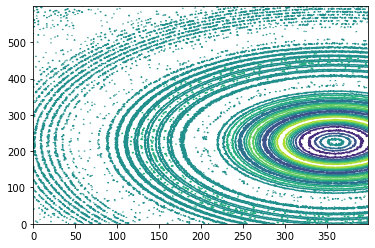

In [ ]:
plt.contour(valid_inputs_scaled_one[1100,:,:,0])

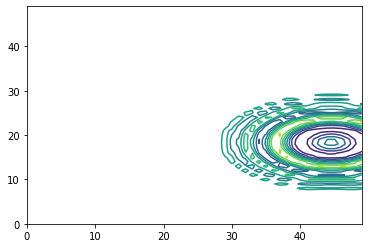

In [ ]:
plt.contour(valid_inputs_scaled_one_rescaled[1100,:,:])

In [ ]:
from sklearn.decomposition import PCA
reshaped_X = train_inputs_scaled_one_rescaled.reshape(6000,2500)
print(train_outputs_one.shape)

(6000, 4)


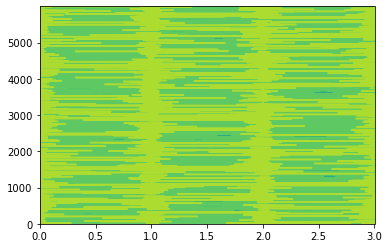

In [ ]:
plt.contour(train_outputs_scaled_one)

In [ ]:
from sklearn.decomposition import PCA
#reshaped_X = train_inputs_scaled_one.reshape(6000,240000)
pca = PCA(n_components=200)
pca.fit_transform(reshaped_X)
#pca.fit_transform(train_inputs_scaled_one)
print(pca.explained_variance_ratio_.cumsum())

[0.00467313 0.00919298 0.01366137 0.01812167 0.02245209 0.0267499
 0.03102273 0.03525019 0.03937353 0.04341452 0.04740127 0.05134853
 0.05528259 0.05917164 0.06303404 0.06686454 0.07065491 0.074421
 0.07812869 0.08178501 0.08536688 0.08892321 0.09246992 0.09597992
 0.09943091 0.10280479 0.10610116 0.10939224 0.11264721 0.11588026
 0.11908289 0.12217826 0.12526187 0.12825775 0.13119957 0.13406241
 0.13689572 0.13971101 0.142418   0.14510092 0.1477674  0.15041569
 0.15304159 0.15562259 0.15815414 0.16067106 0.16317204 0.16563492
 0.16808882 0.17051423 0.17291915 0.17529978 0.17765878 0.18000117
 0.18233447 0.18464936 0.1869531  0.18924487 0.19152148 0.19378807
 0.19603781 0.1982635  0.20048419 0.20268966 0.20488457 0.20707667
 0.20925084 0.21141839 0.21357223 0.21571459 0.21784666 0.21996385
 0.22207448 0.22417618 0.22626203 0.22833721 0.23041138 0.23247562
 0.23452722 0.23657592 0.23860766 0.24063422 0.24265178 0.24466231
 0.2466662  0.24865636 0.2506382  0.25261065 0.25457618 0.2565345

In [ ]:
#X_train = pca.fit_transform(X_train)
reshaped_X_test = valid_inputs_scaled_one_rescaled.reshape(2000,2500)
train_preds_scaled_one= pca.fit_transform(reshaped_X)
valid_preds_scaled_one = pca.transform(reshaped_X_test)
#print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.00467313 0.00919299 0.01366138 0.01812168 0.02245209 0.0267499
 0.03102274 0.03525019 0.03937353 0.04341452 0.04740128 0.05134853
 0.0552826  0.05917165 0.06303404 0.06686453 0.07065491 0.074421
 0.07812868 0.081785   0.08536687 0.08892321 0.09246992 0.09597992
 0.09943092 0.1028048  0.10610116 0.10939223 0.1126472  0.11588024
 0.11908288 0.12217824 0.12526187 0.12825775 0.13119958 0.13406241
 0.13689572 0.13971101 0.14241801 0.14510097 0.14776745 0.15041575
 0.15304165 0.15562265 0.15815417 0.16067109 0.16317205 0.16563493
 0.1680889  0.17051433 0.1729193  0.17529999 0.17765905 0.1800014
 0.18233481 0.18464968 0.18695356 0.18924524 0.19152191 0.19378856
 0.19603823 0.19826387 0.20048465 0.20269057 0.2048853  0.20707774
 0.20925169 0.21141912 0.2135729  0.21571563 0.21784747 0.21996514
 0.22207634 0.22417788 0.22626328 0.22833827 0.23041266 0.23247735
 0.23452945 0.23657809 0.23860997 0.24063623 0.24265379 0.2446638
 0.2466676  0.24865782 0.25063923 0.2526117  0.25457808 0.25653738


#### Task5: Train a linear model-Regression Linear

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(reshaped_X, train_outputs_scaled_one)
print(reg.coef_)
reshaped_X_test = valid_inputs_scaled_one_rescaled.reshape(2000,2500)
valid_preds_scaled_one = reg.predict(reshaped_X_test)

[[ 0.884868    0.8765801  -1.3704183  ... -1.1855812   0.7953577
  -0.5606116 ]
 [ 0.9745214   0.40998375  0.44641173 ... -1.5088567   0.95393604
  -0.71781087]
 [-2.2429657  -1.4713156   2.4328482  ...  1.6122196  -2.6267593
  -1.1187607 ]
 [-1.362542   -1.1333202   1.0098776  ...  0.5100748   0.14905971
  -2.014201  ]]


[[ 0.884868    0.8765801  -1.3704183  ... -1.1855812   0.7953577
  -0.5606116 ]
 [ 0.9745214   0.40998375  0.44641173 ... -1.5088567   0.95393604
  -0.71781087]
 [-2.2429657  -1.4713156   2.4328482  ...  1.6122196  -2.6267593
  -1.1187607 ]
 [-1.362542   -1.1333202   1.0098776  ...  0.5100748   0.14905971
  -2.014201  ]]
(2000, 4)


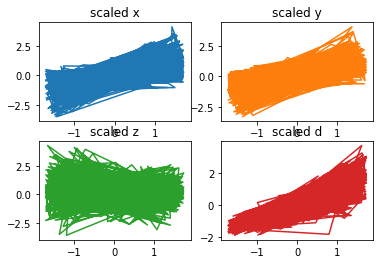

In [ ]:
#print(train_preds_scaled_one.shape)
#inverse=scaler_one.inverse_transform(train_preds_scaled_one)
#train_preds_one= pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one), columns=output_cols_one)
#valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one), columns=output_cols_one)

print(reg.coef_)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(valid_outputs_scaled_one[:,0],valid_preds_scaled_one[:,0])
axs[0, 0].set_title('scaled x')
axs[0, 1].plot(valid_outputs_scaled_one[:,1],valid_preds_scaled_one[:,1], 'tab:orange')
axs[0, 1].set_title('scaled y')
axs[1, 0].plot(valid_outputs_scaled_one[:,2],valid_preds_scaled_one[:,2], 'tab:green')
axs[1, 0].set_title('scaled z')
axs[1, 1].plot(valid_outputs_scaled_one[:,3],valid_preds_scaled_one[:,3], 'tab:red')
axs[1, 1].set_title('scaled d')
print(valid_outputs_scaled_one.shape)

#### Task6: Train a Train a decision tree ensemble method of your choice- RadomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(reshaped_X, train_outputs_scaled_one)
valid_preds_scaled_one=regr.predict(reshaped_X_test)

(2000, 4)
(2000, 4)


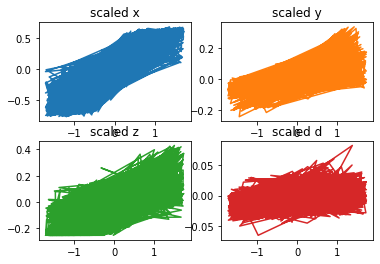

In [ ]:
print(valid_preds_scaled_one.shape)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(valid_outputs_scaled_one[:,0],valid_preds_scaled_one[:,0])
axs[0, 0].set_title('scaled x')
axs[0, 1].plot(valid_outputs_scaled_one[:,1],valid_preds_scaled_one[:,1], 'tab:orange')
axs[0, 1].set_title('scaled y')
axs[1, 0].plot(valid_outputs_scaled_one[:,2],valid_preds_scaled_one[:,2], 'tab:green')
axs[1, 0].set_title('scaled z')
axs[1, 1].plot(valid_outputs_scaled_one[:,3],valid_preds_scaled_one[:,3], 'tab:red')
axs[1, 1].set_title('scaled d')
print(valid_outputs_scaled_one.shape)

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here


#### Task1_Part1: Train a densely connected neural network-Multi-layer Perceptron (MLP) regressor

In [ ]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
#scaler_one = MinMaxScaler()
scaler_one= StandardScaler()
slice_idx = 6000


In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals


In [ ]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
#scaler_one = MinMaxScaler()
scaler_one= StandardScaler()
slice_idx = 6000


In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


Slicing data into inputs/outputs
	- outputs.shape: (6000, 4)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 4)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [ ]:
from sklearn.decomposition import PCA
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print(train_inputs_scaled_one.shape)
train_inputs_scaled_one_rescaled=downscale_local_mean(train_inputs_scaled_one, (1,12, 8,1))
train_inputs_scaled_one_rescaled=train_inputs_scaled_one_rescaled.squeeze()
valid_inputs_scaled_one_rescaled=downscale_local_mean(valid_inputs_scaled_one, (1,12, 8,1))
valid_inputs_scaled_one_rescaled=valid_inputs_scaled_one_rescaled.squeeze()
#image_rescaled = rescale(train_inputs_scaled_one, 0.25, anti_aliasing=False)
print(train_inputs_scaled_one_rescaled.shape)

reshaped_X = train_inputs_scaled_one_rescaled.reshape(6000,2500)
print(train_outputs_one.shape)
reshaped_X_test = valid_inputs_scaled_one_rescaled.reshape(2000,2500)

(6000, 600, 400, 1)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(reshaped_X, train_outputs_scaled_one)
regr.score(reshaped_X, train_outputs_scaled_one)
print(train_outputs_scaled_one.shape)
print(reshaped_X.shape)
#clf.fit(reshaped_X, train_outputs_scaled_one[:,1])

(6000, 4)
(6000, 2500)


(2000, 4)
(2000, 4)


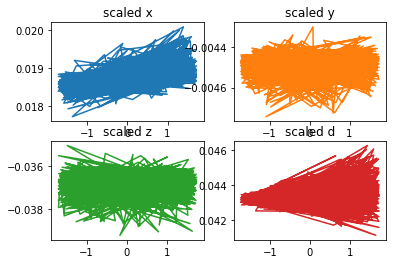

In [ ]:
print(valid_preds_scaled_one.shape)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(valid_outputs_scaled_one[:,0],valid_preds_scaled_one[:,0])
axs[0, 0].set_title('scaled x')
axs[0, 1].plot(valid_outputs_scaled_one[:,1],valid_preds_scaled_one[:,1], 'tab:orange')
axs[0, 1].set_title('scaled y')
axs[1, 0].plot(valid_outputs_scaled_one[:,2],valid_preds_scaled_one[:,2], 'tab:green')
axs[1, 0].set_title('scaled z')
axs[1, 1].plot(valid_outputs_scaled_one[:,3],valid_preds_scaled_one[:,3], 'tab:red')
axs[1, 1].set_title('scaled d')
print(valid_outputs_scaled_one.shape)

#### Task1_Part2: Train a densely connected neural network-keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
model = models.Sequential()
model = models.Sequential([
  Dense(64, activation='relu', input_shape=(240000,)),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax'),
])
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=['binary_accuracy'],
)
print(train_inputs_scaled_one.shape)
train_images = train_inputs_scaled_one.reshape((-1, 240000))
test_images = valid_inputs_scaled_one.reshape((-1, 240000))
#train_images = train_inputs_scaled_one #.reshape((-1, 240000))
print(train_images.shape)
print(train_outputs_scaled_one[:,0].shape)
test_images = valid_inputs_scaled_one #.reshape((-1, 240000))
model.fit(
  train_images, # training data
  train_outputs_scaled_one[:,0], # training targets
  epochs=20,
  batch_size=32,
)

TypeError: ignored

#### Task2_Part1 Train a convolutional or recurrent neural network (depends on problem)-Updated Conv2DNeuralNetwork

In [ ]:
# 1 particle 4D model build, compile, fit, and predict
one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist2=mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time)

In [ ]:
# visualize loss history
plt.plot(hist2[‘loss’])
plt.plot(hist2[‘val_loss’])
plt.title(‘model loss’)
plt.ylabel(‘loss’)
plt.xlabel(‘epoch’)
plt.legend([‘training’, ‘validation’], loc=‘upper left’)
plt.show()

#### Task2_Part2 Train a convolutional or recurrent neural network (depends on problem)-A CNN

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
model = models.Sequential()
model.add(layers.Conv2D(16,(3,3), activation='relu', batch_input_shape=(16,600,400,1)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (16, 598, 398, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 199, 132, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 197, 130, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 98, 65, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 96, 63, 16)          2320      
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
train_inputs_scaled_one_rescaled=downscale_local_mean(train_inputs_scaled_one, (1,12, 8,1))
valid_inputs_scaled_one_rescaled=downscale_local_mean(valid_inputs_scaled_one, (1,12, 8,1))
print(train_inputs_scaled_one.shape)
train_images = train_inputs_scaled_one_rescaled
test_images = valid_inputs_scaled_one_rescaled
#train_outputs_scaled_one=train_outputs_scaled_one.reshape(train_outputs_scaled_one.shape[0], train_outputs_scaled_one.shape[1])
in_shape = test_images.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(16,(3,3), activation='relu', input_shape=in_shape))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.summary()

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (16, 598, 398, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 199, 132, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 197, 130, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 98, 65, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 96, 63, 16)          2320      
_________________________________________________________________
flatten (Flatten)            (16, 96768)               0         
_________________________________________________________________
dense_21 (Dense)             (16, 64)                

In [ ]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
#print(reshaped_X.shape)
train_inputs_scaled_one_rescaled=downscale_local_mean(train_inputs_scaled_one, (1,12, 8,1))
train_inputs_scaled_one_rescaled=train_inputs_scaled_one_rescaled.squeeze()

train_images = train_inputs_scaled_one#.reshape((-1, 240000))
print(train_images.shape)
print(train_outputs_scaled_one[:,0].shape)
test_images = valid_inputs_scaled_one#.reshape((-1, 240000))
#test_images.isnull().any() 
history = model.fit(train_images, train_outputs_scaled_one[:,2], epochs=10,batch_size=16, 
                    validation_data=(test_images, valid_outputs_scaled_one[:,0]))
#history = model.fit(train_images, train_outputs_scaled_one[:,0], batch_size=32,epochs=2),validation_data=(test_images, valid_outputs_scaled_one[:,0]))

(6000, 600, 400, 1)
(6000,)
Epoch 1/10
375/375 [==============================] - 29s 77ms/step - loss: 1.0016 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 2/10
375/375 [==============================] - 29s 76ms/step - loss: 1.0006 - accuracy: 0.0000e+00 - val_loss: 0.9769 - val_accuracy: 0.0000e+00
Epoch 3/10
375/375 [==============================] - 29s 76ms/step - loss: 1.0007 - accuracy: 0.0000e+00 - val_loss: 0.9766 - val_accuracy: 0.0000e+00
Epoch 4/10
375/375 [==============================] - 29s 76ms/step - loss: 1.0005 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 5/10
375/375 [==============================] - 29s 76ms/step - loss: 1.0013 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 6/10
375/375 [==============================] - 29s 77ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 0.9770 - val_accuracy: 0.0000e+00
Epoch 7/10
375/375 [==============================] - 29s 76

63/63 - 3s - loss: 1.9460 - binary_accuracy: 0.0000e+00


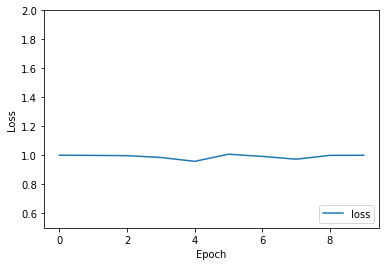

In [ ]:
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 2])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, valid_outputs_scaled_one[:,0], verbose=2)

#### Task3: Experiment with different architectures

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
model = models.Sequential()
model.add(layers.Conv2D(16,(2,2), activation='relu', batch_input_shape=(16,600,400,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (2,2), activation='relu'))
model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (16, 599, 399, 16)        80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (16, 299, 199, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (16, 298, 198, 16)        1040      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (16, 149, 99, 16)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (16, 148, 98, 16)         1040      
Total params: 2,160
Trainable params: 2,160
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                

In [ ]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
#print(reshaped_X.shape)
train_inputs_scaled_one_rescaled=downscale_local_mean(train_inputs_scaled_one, (1,12, 8,1))
train_inputs_scaled_one_rescaled=train_inputs_scaled_one_rescaled.squeeze()

train_images = train_inputs_scaled_one#.reshape((-1, 240000))
print(train_images.shape)
print(train_outputs_scaled_one[:,0].shape)
test_images = valid_inputs_scaled_one#.reshape((-1, 240000))
#test_images.isnull().any() 
history = model.fit(train_images, train_outputs_scaled_one[:,2], epochs=10,batch_size=16, 
                    validation_data=(test_images, valid_outputs_scaled_one[:,0]))
#history = model.fit(train_images, train_outputs_scaled_one[:,0], batch_size=32,epochs=2),validation_data=(test_images, valid_outputs_scaled_one[:,0]))

(6000, 600, 400, 1)
(6000,)
Epoch 1/10
375/375 [==============================] - 34s 91ms/step - loss: 1.6508 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 2/10
375/375 [==============================] - 34s 91ms/step - loss: 1.0001 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 3/10
375/375 [==============================] - 34s 91ms/step - loss: 1.0002 - accuracy: 0.0000e+00 - val_loss: 0.9767 - val_accuracy: 0.0000e+00
Epoch 4/10
375/375 [==============================] - 34s 92ms/step - loss: 1.0002 - accuracy: 0.0000e+00 - val_loss: 0.9766 - val_accuracy: 0.0000e+00
Epoch 5/10
375/375 [==============================] - 34s 91ms/step - loss: 1.0002 - accuracy: 0.0000e+00 - val_loss: 0.9766 - val_accuracy: 0.0000e+00
Epoch 6/10
375/375 [==============================] - 34s 90ms/step - loss: 1.0001 - accuracy: 0.0000e+00 - val_loss: 0.9768 - val_accuracy: 0.0000e+00
Epoch 7/10
375/375 [==============================] - 34s 91

### *Note: Nearly constant loss and zero accuracy, we will work this out in the next couple of days

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# conv2d_network definitions for 1 particle 4D solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "Selu"
filters = [16, 24, 32]
#filters = [4, 6, 8]

kernel_sizes1 = [5, 5, 5]
kernel_sizes2 = [9, 5, 12]
kernel_sizes3 = [3, 3, 3]
conv2d_activation = "relu"
pool_sizes_Mod3 = [4, 4, 4]
dense_sizes = [64, 32]
#dense_sizes = [32, 16]
dense_activation = "selu"
#lr = 0.001
#lr = 0.0001
lr=0.01
optimizer = "adam"
#loss = "mse"
loss = 'mae'
#loss = tf.keras.losses.MeanAbsolutePercentageError()
batch_size = 64
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)

NameError: ignored

In [ ]:
one_start = datetime.now()
with tf.device('/device:GPU:0'):#My_Conv2DNeuralNetwork
    mod4 = My_Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist4=mod4.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod4.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod4.predict(valid_inputs_scaled_one), columns=output_cols_one)



In [ ]:
plt.plot(hist4['loss'], label='loss')
plt.plot(hist4['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.1, .6])
plt.legend(loc='lower right')

In [ ]:
# Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.